<a href="https://colab.research.google.com/github/k2moon/ml-hg/blob/main/hg_05_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치
---

## 핵심 키워드
---
- 검증 세트
- 교차 검증
- 그리드 서치
- 랜덤 서치

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 검증 세트 validation set
---
- 훈련 세트로 모델을 훈련 하고 테스트 세트로 모델 평가의 문제점 => 점점 테스트 세트 잘맞는 모델이 만들어 지게 됨
- 하이퍼파라미터 튜닝을 위해 모델을 평가할 때, 테스트 세트를 사용하지 않기 위해 훈련 세트에서 다시 떼어 낸 데이터 세트
- 훈련 데이터가 아주 많다면 몇 %만 사용 해도 됨
- 훈련 세트로 모델 훈련 후 검증 세트로 검증, 최종 평가에서 테스트 세트 사용

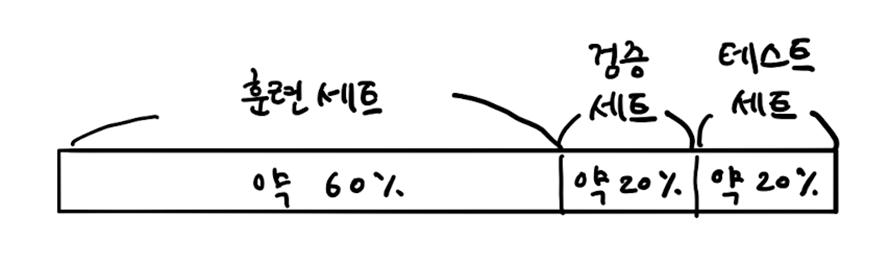

In [1]:
# 데이터 준비
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
# 넘파이 배열로 변환
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
# 훈련 세트와 테스트 세트로 분할
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:
# 훈련 세트와 검증 세트 분할
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [5]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


- 훈련/ 테스트 데이터 분리
- 훈련데이터 안에서 검증 데이터를 또 분리

In [6]:
# 훈련 후 검증 세트로 평가 : 과대 적합
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


- 과대적합
- 검증세트를 만드느라 훈련세트가 줄었음
- 해결법: 교차검증

## 교차 검증 cross validation
---
- k-폴드 교차 검증 k-fold cross validation 사용
- 훈련세트를 여러 폴드로 나눈 다음 한 폴드가 검증세트의 역할을 하고 나머지 폴드에서는 모델 훈련
- 모든 폴드에 대해서 검증 점수를 얻어 평균하는 방법
- 훈련 데이터의 양이 적을 때 효율 적임


### 3-폴드 교차 검증 k-folt cross validation
---
- 보통 5-폴드 교차 검증이나 10-폴드 교차 검증이 많이 사용됨

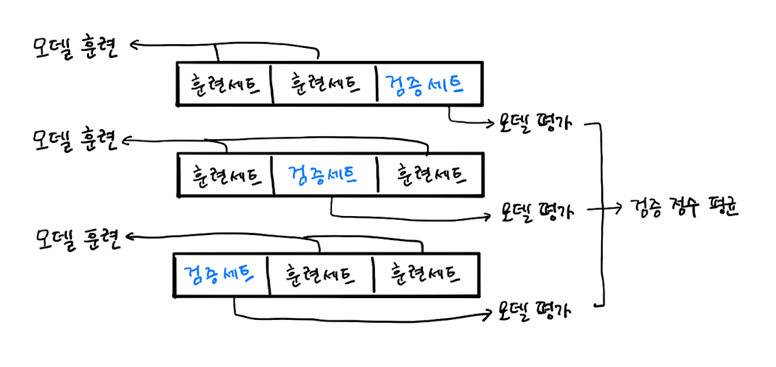

### 사이킷런 cross_validate() 교차 검증 함수
---
- 평가할 모델 객체와 훈련 세트를 전달, 직접 검증세트를 지정안해줘도됨
- 훈련 세트를 섞어 폴드 만들려면  분할기 splitter 지정해야 함
- 회귀모델의 경우 KFold, 분류모델의 경우 StratifiedKFold를 사용
- cv 매개변수로 폴드수 지정, 기본값으로 5-폴드 교차 검증 수행
- fit_time 각 모델 훈련 시간 
- score_time 각 모델 검증 시간
- test_score 각 검증 세트 평가 값

In [10]:
# 교차 검증 수행
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target, cv=5)
print(scores)

{'fit_time': array([0.0076046 , 0.00735307, 0.01424313, 0.01123214, 0.00719643]), 'score_time': array([0.000844  , 0.00076675, 0.0010376 , 0.00093484, 0.00048923]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [8]:
# 교차 검증 평균 : 검증 폴드 점수
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


In [13]:
# 섞기 위한 분할기 지정 StratifiedKFold
# 앞서 전체 데이터를 섞은 후 나눠줬기때문에 평가 값은 동일함
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


- 앞서 전체 데이터를 섞은 후 나눠줬기 때문에 섞을 필요는 없음
- 교차검증을 할때 훈련세트를 섞으려면 분할기를 지정해줘야함
- 회귀모델의 경우 KFold, 분류모델의 경우 StratifiedKFold를 사용

In [14]:
# 만약 폴드 값을 변경해서 교차검증을 하고싶다면 splitter에 생성 후 cv에 지정 해줌
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


- 만약 10-폴드 교차검증을 하고싶다면 splitter에 저장한 후 넣어줌

## 하이퍼파라미터
---
- 모델이 학습할 수 없어 사용자가 지정해야만 하는 파라미터
- 모델파라미터 : 모델이 학습하는 파라미터
- AutoML : 사람의 개입 없이 하이퍼파라미터 튜닝을 자동 수행하는 기술

### 하이퍼파라미터 튜닝
---
- 기본값으로 모델 훈련
- 검증 세트 점수나 교차 검증을 통해 하이퍼파라미터 매개변수를 바꿔 가며 확인
- 모델 마다 적게는 1 ~ 2개, 많게는 5 ~ 6개의 매개변수 제공
- 매개 변수들은 동시에 바꿔가며 최적의 값을 찾아야 함




### 그리드 서치 Grid Search
---
- GridSearchCV 클래스 사이킷런에서 제공
- 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행
- 그리드서치 클래스를 임포트하고 탐색할 매개변수의 값의 리스트를 딕셔너리로 만듬

In [16]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [17]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

- 그리드서치 클래스에 탐색대상모델과 params의 변수를 전달하여 그리드서치 객체 생성
- n_jobs에 -1을 지정하면 시스템의 모든 코어를 사용

In [18]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [19]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [20]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


- gs 객체에 fit 메서드를 호출하면 min_impurity_decrease (5) * 교차검증(5) =25개의 모델을 훈련
- 검증 점수가 가장 높은 하이퍼파라미터로 훈련한 모델은 `best_estimator_` 에 저장
- 최적의 매개변수는 `best_params_` 에 저장되어있음

In [21]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


- 5번의 교차 검증으로 얻은 점수
- 최적의 하이퍼파라미터인 0.0001 에 있는 위치의 점수가 역시 가장 높음

In [22]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


- 넘파이 argmax() 함수로 가장 큰 값의 인덱스를 추출
- 넘파이 argmin() 함수로 가장 작은 값의 인덱스를 추출

In [23]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001), # 노드 분할을 위한 불순도 감소 최소량
          'max_depth': range(5, 20, 1), # 트리 깊이 제한
          'min_samples_split': range(2, 100, 10) # 노드 분할을 위한 최소 샘플 수
          }

In [25]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

- 교차검증횟수는 9 * 15 * 10 = 1350번
- 5-폴드 검증을 수행하므로 만들어지는 모델은 1350 * 5 =6750 개

In [26]:
# 최상의 매개변수 조합 확인
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [27]:
# 최상이 교차 검증 점수
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치 Random Search
---
- 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 때
- 너무 많은 매개변수 조건이 있어 그리드 서치 수행 시간이 너무 오래 걸릴 때
- 기존 그리스 서치보다 훨씬 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색 가능

In [28]:
from scipy.stats import uniform, randint

In [29]:
# 0 ~ 10 사이 정수 10개
rgen = randint(0, 10)
rgen.rvs(10)

array([5, 1, 2, 4, 1, 8, 5, 7, 4, 0])

In [34]:
# 0 ~ 9 사이 정수 1000개 분포
np.unique(rgen.rvs(1000), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 87,  93,  80,  77, 104,  94, 102,  94,  90,  83,  96]))

In [33]:
# 0 ~ 1 사이 실수 10개
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.06353202, 0.02395553, 0.54586774, 0.44919993, 0.47578843,
       0.49535713, 0.17240337, 0.00818826, 0.17032019, 0.70863228])

In [36]:
# 탐색 매개변수 지정
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25), # 리프 노드(마지막 노드)가 되기 위한 최소 샘플 수
          }

In [37]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54690>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54f50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54550>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e540d0>},
                   random_state=42)

- n_iter로 샘플링 횟수를 지정
- 샘플링 횟수는 시스템 자원이 허락하는 범위내에서 최대한 크게 지정

In [38]:
# 최적의 매개변수 조합
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [39]:
# 최고의 교차 검증 점수
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [41]:
# 최적의 모델로 테스트 세트 평가
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


## 확인문제
---
- RandomizedSearchCV 클래스에 DecisionTreeClassifier 클래스 splitter값 변경 해서 테스트
- 기본값은 splitter='best' 각 노드에서 최선의 분할 찾기
- splitter='random' 무작위 분할 후 가장 좋은 거 찾기
- 성능 비교

In [42]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54690>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54f50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e54550>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ea0e540d0>},
                   random_state=42)

In [43]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
